# NLP with TensorFlow/Keras on the IMDb Movie Reviews dataset

IMDb Movie Reviews dataset is a binary sentiment analysis dataset consisting of 50000 reviews from the Internet Movie Database (IMDb) labeled as positive or negative. 

Objective: Try different Deep Learning approaches on the imdb movie reviews dataset.

- Baseline: BoW
- Fully Connected Neural Network
- Word Embeddings
- LSTM

In [1]:
import tensorflow as tf 
import tensorflow_datasets as tfds
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt 
import numpy as np
import random
from sklearn.manifold import TSNE
import seaborn as sns 
from scipy import spatial
from sklearn.naive_bayes import GaussianNB
from scipy.spatial import distance

### Load data

In [2]:
dataset, info = tfds.load(
    'imdb_reviews/plain_text',
    #train, validate, test
    split=['train[:80%]', 'train[80%:]', 'test'],
    as_supervised=True,
    with_info=True
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteG5IU2G/imdb_reviews-train.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteG5IU2G/imdb_reviews-test.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteG5IU2G/imdb_reviews-unsupervised.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [3]:
#get train, validation anbd test data
dataset_train_original = dataset[0]
dataset_validate_original = dataset[1]
dataset_test_original = dataset[2]

info

tfds.core.DatasetInfo(
    name='imdb_reviews',
    version=1.0.0,
    description='Large Movie Review Dataset.
This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.',
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
        'text': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=100000,
    splits={
        'test': 25000,
        'train': 25000,
        'unsupervised': 50000,
    },
    supervised_keys=('text', 'label'),
    citation="""@InProceedings{maas-EtAl:2011:ACL-HLT2011,
      author    = {Maas, Andrew L.  and  Daly, Raymond E.  and  Pham, Peter T.  and  Huang, Dan  and  Ng, Andrew Y.  and  Potts, Christopher},
      title     = {Learning Word

### Explore data

In [4]:
for x, y in dataset_train_original.shuffle(2500).take(8):
  print('Input:', x.numpy().decode('utf-8'))
  print('Output:', y.numpy())
  print('\n')

Input: Basically, the movie might be one of the most mesmerizing titles made by either of the two Scotts(Ridley and Tony). Let's make it straight, the movie deserved its hype as one of the most stylish actioner/thriller ever made.<br /><br />When it comes to disgruntled tragic heroes, Denzel Washington and Tony Scotts really make a perfect duo. Both this movie and Deja Vu are better thrillers you can expect. Washington really got very comfortable in the shaky cameras and every executing scenes in the movie. One would easily be related to his character's emotions therefore enjoyed all the killings on the road. It's a success that they created a super-dark Mexico city with a lot of shits happening. One would be easily convinced by the extent of corruption depicted in Man On Fire. I don't know what would the Mexicans think when they watch this......<br /><br />Well, let's face it again. It's among the best of the Death Wish genre, but it also suffered from extensive amount of violence. It

Length of reviews

In [5]:
lengths = []
labels = []

for x, _ in dataset_train_original:
  lengths.append(len(x.numpy()))
  labels.append(y.numpy())

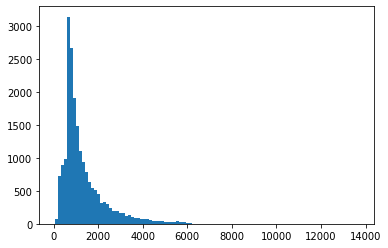

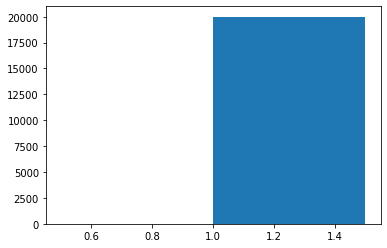

In [6]:
plt.hist(lengths, bins=100)
plt.show()
plt.close()

plt.hist(labels, bins=2)
plt.show()
plt.close()

## Baseline model: BoW

In [7]:
#hyperparameter
vocabulary_size = 10000

#encoder takes string, cleans and maps them to 0 and 1
encoder = layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize="lower_and_strip_punctuation",
    output_mode="multi_hot"
)

In [8]:
#drops label and returns encoded text
encoder.adapt(dataset_train_original.map(lambda text, label: text).batch(2048))

In [9]:
len(encoder.get_vocabulary())

10000

In [10]:
#encoding
text = "This is a test."
print("Original:", text)

def multi_hot_to_string(multi_hot):
  return "".join([str(int(x)) for x in multi_hot])

text_encoded = encoder(text).numpy()
print("Encoded:", multi_hot_to_string(text_encoded))
print("Length:", len(text_encoded))

Original: This is a test.
Encoded: 00010010001000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

Prepare data for training, model takes numpy array as input.

In [11]:
def dataset_to_numpy(dataset):
  '''encodes text and gets numpy array
  '''
  x_input = []
  y_output = []
  for x, y in dataset.batch(2048):
    #0 and 1 encodings
    x =  encoder(x).numpy()
    x_input.extend(x)
    y_output.extend(y.numpy())
  x_input = np.array(x_input)
  y_input = np.array(y_output)
  return x_input, y_output


x_train, y_train = dataset_to_numpy(dataset_train_original)
x_test, y_test = dataset_to_numpy(dataset_test_original)

x_train[0], y_train[0]

(array([1., 1., 1., ..., 0., 0., 0.], dtype=float32), 0)

In [12]:
#train on Naive Bayes model

model = GaussianNB()
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
correct_predictions = (y_test == y_pred).sum()
accuracy = correct_predictions / len(x_test)
print(f"{100 * accuracy:.02f}% accuracy on test")

70.05% accuracy on test


## Fully Connected Neural Network

In [13]:
#shuffle to prevent overfitting
#chache speeds up training

dataset_train = dataset_test_original.cache().batch(128).shuffle(25000)

dataset_validate = dataset_validate_original.cache().batch(128) 

In [14]:
model = models.Sequential()

model.add(encoder)

model.add(layers.Dense(32, activation="relu"))
#sigmoid for binary classification
model.add(layers.Dense(1, activation="sigmoid"))

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 10000)            0         
 torization)                                                     
                                                                 
 dense (Dense)               (None, 32)                320032    
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 320,065
Trainable params: 320,065
Non-trainable params: 0
_________________________________________________________________


In [15]:
model.compile(
    loss="binary_crossentropy", #for two classes
    optimizer="adam", #adam always good to use
    metrics=["accuracy"]
)

In [16]:
model.fit(
    dataset_train,
    epochs=10, #hyperparmeter to tune!
    validation_data=dataset_validate
)

Epoch 1/10
196/196 [==============================] - 8s 19ms/step - loss: 0.3385 - accuracy: 0.8652 - val_loss: 0.2888 - val_accuracy: 0.8856
Epoch 2/10
196/196 [==============================] - 3s 15ms/step - loss: 0.1887 - accuracy: 0.9287 - val_loss: 0.3099 - val_accuracy: 0.8794
Epoch 3/10
196/196 [==============================] - 3s 15ms/step - loss: 0.1446 - accuracy: 0.9482 - val_loss: 0.3475 - val_accuracy: 0.8756
Epoch 4/10
196/196 [==============================] - 3s 15ms/step - loss: 0.1169 - accuracy: 0.9590 - val_loss: 0.3877 - val_accuracy: 0.8682
Epoch 5/10
196/196 [==============================] - 3s 15ms/step - loss: 0.0953 - accuracy: 0.9680 - val_loss: 0.4436 - val_accuracy: 0.8646
Epoch 6/10
196/196 [==============================] - 3s 15ms/step - loss: 0.0774 - accuracy: 0.9754 - val_loss: 0.5079 - val_accuracy: 0.8604
Epoch 7/10
196/196 [==============================] - 3s 15ms/step - loss: 0.0633 - accuracy: 0.9812 - val_loss: 0.5521 - val_accuracy: 0.8590

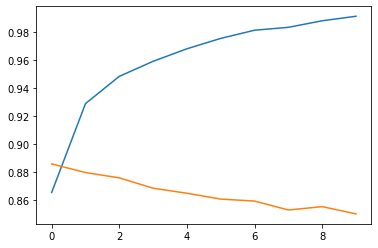

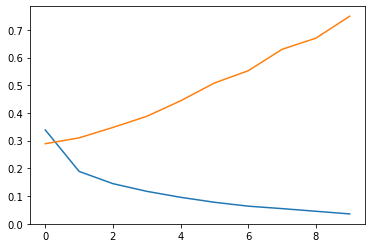

In [17]:
plt.plot(model.history.history["accuracy"],label="accuracy")
plt.plot(model.history.history["val_accuracy"],label="val_accuracy")
plt.show()
plt.close()

plt.plot(model.history.history["loss"], label="loss")
plt.plot(model.history.history["val_loss"],label="val_loss")
plt.show()
plt.close()

We are really overfitting.

In [18]:
text = "This movie is awful. Terrible"
prediction = model.predict([text])
print(model.predict([text]))

[[0.02406696]]


## Word Embeddings

Represent words as vectors.

Data Preparation

In [19]:
tf.keras.backend.clear_session()

In [20]:
vocabulary_size = 10000
#cut reviews that are longer than 128 characters
sequence_length = 128

#gives us vector as number
encoder = layers.TextVectorization(
    max_tokens=vocabulary_size,
    output_sequence_length=sequence_length,
    standardize="lower_and_strip_punctuation",
    split="whitespace",
    #not multi_hot anymore!
    output_mode="int")

In [21]:
#drops label, returns encoded text
encoder.adapt(dataset_train_original.map(lambda text, label: text).batch(2048))

In [22]:
text = "This is a test."
print("Original:", text)

#encoder: makes sur everything is the same size
def index_sequence_to_string(index_sequence):
  return ", ".join([str(x) for x in index_sequence])
text_encoded = encoder(text)
print("Indices:", index_sequence_to_string(text_encoded.numpy()))

Original: This is a test.
Indices: 11, 7, 4, 2104, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0


In [23]:
#decoding
def decode(index_sequence):
  vocabulary = encoder.get_vocabulary()
  strings = [vocabulary[index] for index in index_sequence]
  return " ".join(strings)
text_decoded = decode(text_encoded)
print("Decoded:", text_decoded)

Decoded: this is a test                                                                                                                            


Every word gets an identifier. Word order stays intact. Difference to BoW!

In [24]:
model = models.Sequential()

model.add(encoder)

#Embedding layer is always the first layer
model.add(layers.Embedding(input_dim=vocabulary_size, output_dim=32))

model.add(layers.Flatten()),
model.add(layers.Dense(512, activation="relu")),
model.add(layers.Dense(1,activation="sigmoid"))

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 128)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 128, 32)           320000    
                                                                 
 flatten (Flatten)           (None, 4096)              0         
                                                                 
 dense (Dense)               (None, 512)               2097664   
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 2,418,177
Trainable params: 2,418,177
Non-trainable params: 0
______________________________________________

In [25]:
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

In [26]:
model.fit(
    dataset_train,
    epochs=10,
    validation_data=dataset_validate
)

Epoch 1/10
196/196 [==============================] - 4s 19ms/step - loss: 0.4891 - accuracy: 0.7372 - val_loss: 0.3877 - val_accuracy: 0.8300
Epoch 2/10
196/196 [==============================] - 3s 17ms/step - loss: 0.1721 - accuracy: 0.9356 - val_loss: 0.5277 - val_accuracy: 0.7940
Epoch 3/10
196/196 [==============================] - 3s 17ms/step - loss: 0.0233 - accuracy: 0.9947 - val_loss: 0.7279 - val_accuracy: 0.7934
Epoch 4/10
196/196 [==============================] - 4s 18ms/step - loss: 0.0025 - accuracy: 0.9999 - val_loss: 0.8335 - val_accuracy: 0.7952
Epoch 5/10
196/196 [==============================] - 3s 17ms/step - loss: 6.0908e-04 - accuracy: 1.0000 - val_loss: 0.8694 - val_accuracy: 0.7984
Epoch 6/10
196/196 [==============================] - 3s 17ms/step - loss: 3.4076e-04 - accuracy: 1.0000 - val_loss: 0.9044 - val_accuracy: 0.7990
Epoch 7/10
196/196 [==============================] - 3s 18ms/step - loss: 2.3177e-04 - accuracy: 1.0000 - val_loss: 0.9324 - val_accu

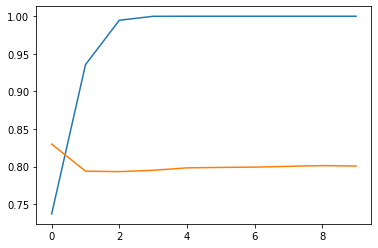

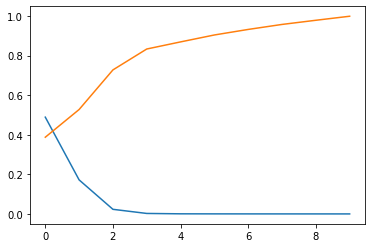

In [27]:
plt.plot(model.history.history["accuracy"],label="accuracy")
plt.plot(model.history.history["val_accuracy"],label="val_accuracy")
plt.show()
plt.close()

plt.plot(model.history.history["loss"], label="loss")
plt.plot(model.history.history["val_loss"],label="val_loss")
plt.show()
plt.close()
#Overfitting!

In [28]:
prediction = model.predict(["This movie as awful.Terrible."])[0]
prediction

array([0.0398664], dtype=float32)

## LSTM

Long short-term memory 

In [33]:
tf.keras.backend.clear_session()

In [34]:
model = models.Sequential()

model.add(encoder)

model.add(layers.Embedding(input_dim=vocabulary_size, output_dim=8))

#return sequence returns the hidden state, otherwise it woudn't be tractable for the next layer.
model.add(layers.LSTM(64, return_sequences=True))
model.add(layers.LSTM(72, return_sequences=True)) 
model.add(layers.LSTM(98))

model.add(layers.Dense(1, activation="sigmoid"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 128)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 128, 8)            80000     
                                                                 
 lstm (LSTM)                 (None, 128, 64)           18688     
                                                                 
 lstm_1 (LSTM)               (None, 128, 72)           39456     
                                                                 
 lstm_2 (LSTM)               (None, 98)                67032     
                                                                 
 dense (Dense)               (None, 1)                 99        
                                                        

In [35]:
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.fit(
    dataset_train,
    epochs=10,
    validation_data=dataset_validate
)

Epoch 1/10
196/196 [==============================] - 31s 128ms/step - loss: 0.5320 - accuracy: 0.7002 - val_loss: 0.4261 - val_accuracy: 0.8118
Epoch 2/10
196/196 [==============================] - 24s 122ms/step - loss: 0.3072 - accuracy: 0.8756 - val_loss: 0.4047 - val_accuracy: 0.8212
Epoch 3/10
196/196 [==============================] - 24s 122ms/step - loss: 0.2497 - accuracy: 0.9059 - val_loss: 0.4355 - val_accuracy: 0.8148
Epoch 4/10
196/196 [==============================] - 24s 122ms/step - loss: 0.2068 - accuracy: 0.9233 - val_loss: 0.4688 - val_accuracy: 0.8114
Epoch 5/10
196/196 [==============================] - 24s 122ms/step - loss: 0.1858 - accuracy: 0.9342 - val_loss: 0.5789 - val_accuracy: 0.8074
Epoch 6/10
196/196 [==============================] - 24s 122ms/step - loss: 0.1709 - accuracy: 0.9409 - val_loss: 0.4979 - val_accuracy: 0.8026
Epoch 7/10
196/196 [==============================] - 24s 122ms/step - loss: 0.1479 - accuracy: 0.9516 - val_loss: 0.5765 - val_ac

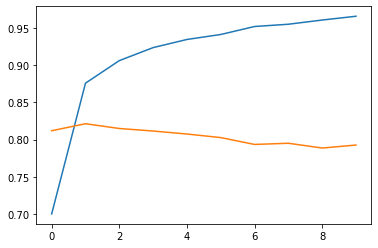

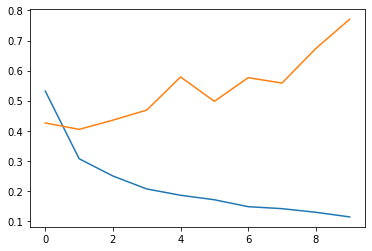

In [36]:
plt.plot(model.history.history["accuracy"],label="accuracy")
plt.plot(model.history.history["val_accuracy"],label="val_accuracy")
plt.show()
plt.close()

plt.plot(model.history.history["loss"], label="loss")
plt.plot(model.history.history["val_loss"],label="val_loss")
plt.show()
plt.close()
#Overfitting!